# Classification Workflow

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, roc_curve

# Objectives

> The goal here is to illustrate a possible workflow for classification modeling with `sklearn`'s `LogisticRegression` model.


- Formulate and implement an iterative modeling workflow
- Implement pipeline workflow to improve efficiency

# Modeling Walkthrough

## Modeling Steps

1. Build a model based on the [Titanic dataset](https://www.kaggle.com/c/titanic/data) that predicts whether a given person survived or not
2. Evaluate the performance of the model
3. Make changes in an attempt to improve the model
4. Demonstrate whether an improvement was made

## The Data

This dataset has the following columns:

| Variable | Definition | Key |
| -------- | ---------- | --- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex | |
| Age | Age in years | |
| sibsp | # of siblings / spouses aboard the Titanic | |
| parch | # of parents / children aboard the Titanic | |
| ticket | Ticket number | |
| fare | Passenger fare | |
| cabin | Cabin number | |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

## Initial Data Understanding and Preparation

Open up the file, get everything into `X` features and `y` target variables, divided into train and test.

In [2]:
df = pd.read_csv("data/titanic.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [7]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age data is missing for about 1 in 5 rows in our dataset.  For now, let's just exclude it, plus the non-numeric columns, and `PassengerId`, which doesn't seem like a real feature, but rather just an artifact of the dataset.

In [9]:
df = df.drop("PassengerId", axis=1)

In [10]:
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [11]:
# Pclass are numbers but it's not clear that the difference between 1st and 2nd is the
# same as the difference between 2nd and 3rd
numeric_columns = ["Survived", "SibSp", "Parch", "Fare"]

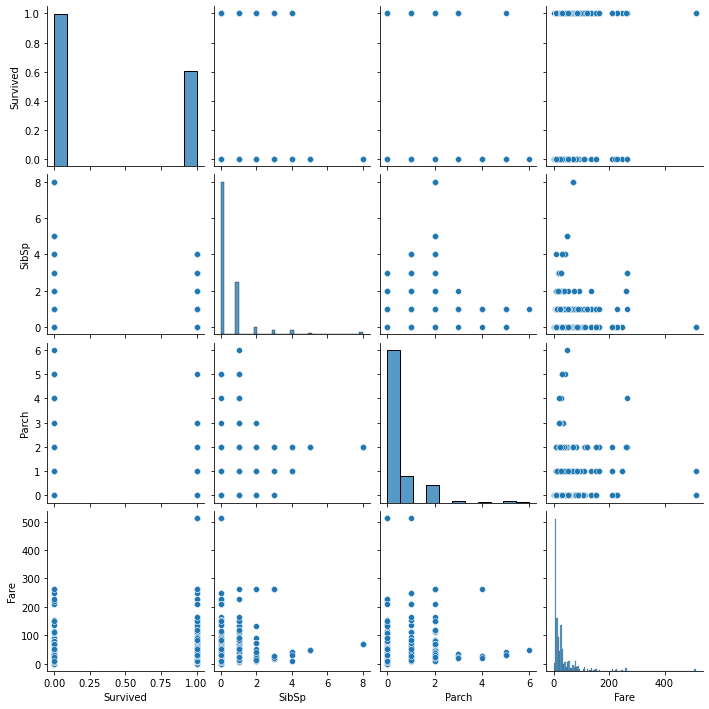

In [12]:
sns.pairplot(df[numeric_columns]);

In [13]:
numeric_df = df[numeric_columns]
X = numeric_df.drop("Survived", axis=1)
y = numeric_df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

# 1st Model - "Dummy" Model

Let's start with a completely "dummy" model, that will always choose the majority class.

In [14]:
y.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [15]:
dummy_model = DummyClassifier(strategy="most_frequent")

Fit the model on our data

In [16]:
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

We should expect all predictions to be the same

In [17]:
# just grabbing the first 50 to save space
dummy_model.predict(X_train)[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [20]:
y_train.value_counts(normalize=True)

0    0.615269
1    0.384731
Name: Survived, dtype: float64

In [19]:
dummy_model.score(X_train, y_train)

0.6152694610778443

## Model Evaluation

Let's do some cross-validation to see how the model would do in generalizing to new data it's never seen.

In [21]:
cv_results = cross_val_score(dummy_model, X_train, y_train, cv=5)
cv_results.mean()

0.6152732577712939

So, the mean accuracy is a little under 62% if we always guess the majority class.

To show the spread, let's make a convenient class that can help us organize the model and the cross-validation:

In [22]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [23]:
dummy_model_results = ModelWithCV(
                        model=dummy_model,
                        model_name='dummy',
                        X=X_train, 
                        y=y_train
)

CV Results for `dummy` model:
            0.61529 ± 0.00532 accuracy
        


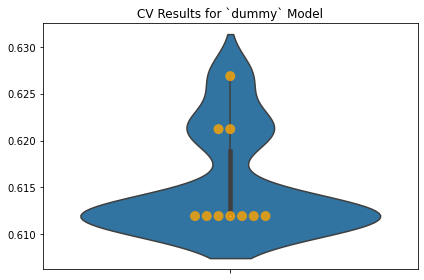

In [24]:
fig, ax = plt.subplots()

ax = dummy_model_results.plot_cv(ax)
plt.tight_layout();

dummy_model_results.print_cv_summary()

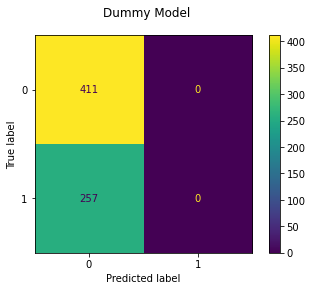

In [25]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

ConfusionMatrixDisplay(confusion_matrix(y_train, dummy_model.predict(X_train))).plot(ax=ax);

A pretty lopsided confusion matrix!

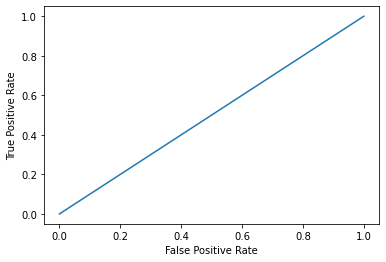

In [26]:
fpr, tpr, thresholds = roc_curve(y_train, dummy_model.predict_proba(X_train)[:,1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot();

In [27]:
dummy_model.predict_proba(X_train)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

# 2nd Model - Logistic Regression

Let's use a logistic regression and compare its performance.

We're going to specifically avoid any regularization (the default) to see how the model does with little change. So we'll pass `'none'` to the `penalty` parameter to not use any regularization. 

In [30]:
X_train

,SibSp,Parch,Fare
316,1,0,26.000
289,0,0,7.750
344,0,0,13.000
220,0,0,8.050
11,0,0,26.550
...,...,...,...
732,0,0,0.000
695,0,0,13.500
454,0,0,8.050
537,0,0,106.425


In [28]:
simple_logreg_model = LogisticRegression(random_state=2023, penalty='none')

In [29]:
simple_logreg_model.fit(X_train, y_train)

LogisticRegression(penalty='none', random_state=2023)

Look at the predictions:

In [31]:
simple_logreg_model.predict(X_train)[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0])

Mixture of 1s and 0s this time

## Model Evaluation, Part 2

In [32]:
simple_logreg_results = ModelWithCV(
                        model=simple_logreg_model,
                        model_name='simple_logreg',
                        X=X_train, 
                        y=y_train
)

CV Results for `simple_logreg` model:
            0.68268 ± 0.03541 accuracy
        


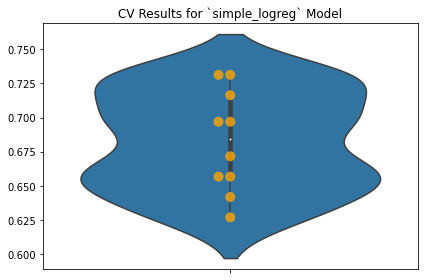

In [33]:
# Saving variable for convenience
model_results = simple_logreg_results

# Plot CV results
fig, ax = plt.subplots()
ax = model_results.plot_cv(ax)
plt.tight_layout();
# Print CV results
model_results.print_cv_summary()

In [34]:
simple_logreg_model.score(X_train, y_train)

0.6856287425149701

So the mean accuracy is better when the model is actually taking in information from the features instead of always guessing the majority class.

In [35]:
confusion_matrix(y_train, simple_logreg_model.predict(X_train))

array([[380,  31],
       [179,  78]])

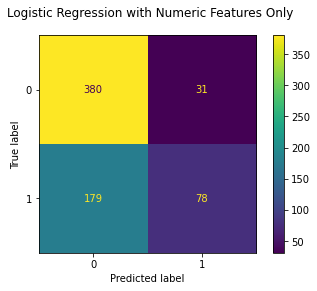

In [36]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with Numeric Features Only")

ConfusionMatrixDisplay(confusion_matrix(y_train, simple_logreg_model.predict(X_train))).plot(ax=ax);

So, in general we are not labeling many of the "not survived" passengers as "survived", but for "survived" passengers we're getting it wrong most of the time.

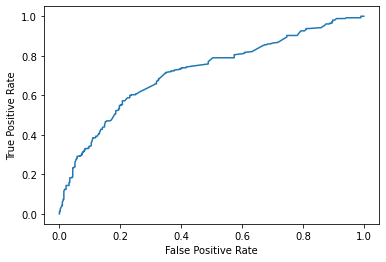

In [37]:
fpr, tpr, thresholds = roc_curve(y_train, simple_logreg_model.predict_proba(X_train)[:,1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot();

This model is doing better than just choosing the most frequent class every time, but it probably could do better. 

We can say this model is likely underfitting, which means we need _more complexity_. We can add more complexity a few different ways. We'll try doing some feature engineering/data preparation.

# Back to Data Preparation

Maybe there is some useful information in the features we are not using yet.  Let's go wild and add all of them!

> Note: you can and should add features incrementally in a "real" modeling context.  The engineering effort of encoding the variables can be non-trivial!  But here let's assume that it's not too much work to encode all of them.

Start with a new train-test split that contains all of the features

In [38]:
X = df.drop("Survived", axis=1)
y = df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

In [39]:
X_train.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

In [40]:
X_train.isna().sum()

Pclass        0
Name          0
Sex           0
Age         139
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       514
Embarked      1
dtype: int64

# Better Process: Pipelines

> **Pipelines** can keep our code neat and clean all the way from gathering & cleaning our data, to creating models & fine-tuning them!

![](https://imgs.xkcd.com/comics/data_pipeline.png)

The `Pipeline` class from [Scikit-Learn's API](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) is especially convenient since it allows us to use our other Estimators that we know and love!

## Advantages of `Pipeline`

### Reduces Complexity

> You can focus on particular parts of the pipeline one at a time and debug or adjust parts as needed.

### Convenient

> The pipeline summarizes your fine-detail steps. That way you can focus on the big-picture aspects.

### Flexible

> You can use pipelines with different models and with GridSearch.

### Prevent Mistakes

> We can focus on one section at a time.
>
> We also can ensure data leakage between our training and doesn't occur between our training dataset and validation/testing datasets!

### Introducing Column Transformer

> Allows one to run different transformers on seperate columns in seamless step with each other. Let's try to add in imputation, and One Hot Encoding. We are creating 'mini' pipelines for each step.

## Handling Missing Values

Let's be extra cautious and make a separate column to indicate whether there originally was a missing value.

In our training data there are only missing values for a couple of the columns, but we can't be sure about where the test set will be missing data.

The `MissingIndicator` from `sklearn` will mark the missing values in an input array.

In [41]:
indicator_demo = MissingIndicator()

indicator_demo.fit(X_train)

indicator_demo.features_

array([3, 8, 9])

In [42]:
indicator_demo.transform(X_train)[:5, :]

array([[False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False, False, False]])

In [43]:
X_train.iloc[:5, [3, 8, 9]]

,Age,Cabin,Embarked
316,24.0,NaN,S
289,22.0,NaN,Q
344,36.0,NaN,S
220,16.0,NaN,S
11,58.0,C103,S


In [44]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [45]:
df['Cabin'].value_counts()

G6             4
C23 C25 C27    4
B96 B98        4
C22 C26        3
F33            3
              ..
B80            1
A36            1
D37            1
B73            1
A23            1
Name: Cabin, Length: 147, dtype: int64

Now that we've specified which values were originally missing, let's fill in those missing values.  This takes two separate imputers because we want to use the mean for numeric data and the majority class for categorical data.

The `SimpleImputer` class fills in the mean value by default, so we'll have to override that for the categorical columns.

In [46]:
# Imputers
num_imput = SimpleImputer(add_indicator=True)
cat_imput = SimpleImputer(strategy='constant', fill_value='Unknown', add_indicator=True)

# Pipelines
num_pipeline = Pipeline(steps=[('impute_num', num_imput)])

## One-Hot Encoding

In [ ]:
# if you wanted to drop
def drop_func():
    pass
    
from sklearn.preprocessing import FunctionTransformer    

drop_sklearn = FunctionTransformer(drop_func)

Now that there are no missing values, convert all of the categorical features into numbers.

In [53]:
cat_pipeline = Pipeline(steps=[
    ('impute_cat', cat_imput),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

### Bring them back together

In [54]:
X_train.head(1)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
316,2,"Kantor, Mrs. Sinai (Miriam Sternin)",female,24.0,1,0,244367,26.0,NaN,S


In [55]:
num_feats = ['Age', 'SibSp', 'Parch', 'Fare']
cat_feats = ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [56]:
col_tr = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                        ('cat', cat_pipeline, cat_feats)],
                          remainder='passthrough', sparse_threshold=0)

In [57]:
col_tr

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('num',
                                 Pipeline(steps=[('impute_num',
                                                  SimpleImputer(add_indicator=True))]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute_cat',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin',
                                  'Embarked'])])

In [58]:
# Train
col_tr.fit_transform(X_train).shape

(668, 1349)

In [60]:
col_tr.fit_transform(X_train)

array([[24.        ,  1.        ,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [22.        ,  0.        ,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [36.        ,  0.        ,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [29.51071834,  0.        ,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [30.        ,  0.        ,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [18.        ,  0.        ,  1.        , ...,  1.        ,
         1.        ,  0.        ]])

In [59]:
# Test
col_tr.transform(X_test).shape

(223, 1349)

In [61]:
df['Name'].value_counts()

Greenberg, Mr. Samuel                              1
Sloper, Mr. William Thompson                       1
Stephenson, Mrs. Walter Bertram (Martha Eustis)    1
Baumann, Mr. John D                                1
Ilmakangas, Miss. Pieta Sofia                      1
                                                  ..
Sandstrom, Miss. Marguerite Rut                    1
Endres, Miss. Caroline Louise                      1
Vander Cruyssen, Mr. Victor                        1
Hagland, Mr. Ingvald Olai Olsen                    1
Najib, Miss. Adele Kiamie "Jane"                   1
Name: Name, Length: 891, dtype: int64

In [62]:
df['Ticket'].value_counts()

CA. 2343       7
1601           7
347082         7
3101295        6
347088         6
              ..
113056         1
248698         1
2662           1
SC/AH 29037    1
113804         1
Name: Ticket, Length: 681, dtype: int64

This is...a ridiculous number of columns.  How did we end up with more columns than rows?

# 3rd Model - After More Data Preparation

Let's run a logistic regression:
> We can incorporate both our Column Transformer and a model into a final top level Pipeline

In [63]:
# Bring in column transformer and a last step estimator/model
log_pipe = Pipeline(steps=[('ct', col_tr),
                           ('logreg', LogisticRegression(random_state=42, penalty='none'))])

log_pipe.fit(X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe

What happened there?  This solver had no problem before.

## Hyperparameter Adjustments to the Model

Let's try a couple of stopgap measures to get the model to run.

### More Iterations

Allows for more iterations to find a solution

In [64]:
log_pipe2 = log_pipe = Pipeline(steps=[('ct', col_tr), 
                           ('logreg', LogisticRegression(random_state=42, penalty='none',
                                                         max_iter = 1000))])

log_pipe2.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe

### More Regularization

Remember that the `C` parameter is the inverse of the regularization strength.

> Note: We could do regularization but we should first scale our features. We're actually going to skip this hyperparameter until we scale our data 

### Higher Tolerance

A higher tolerance means that the model will stop training earlier (when predictions and true values aren't as close as they could be).

In [65]:
log_pipe3 = Pipeline(steps=[('ct', col_tr), 
                           ('logreg', LogisticRegression(random_state=42, penalty='none', 
                                                         tol=25))])

log_pipe3.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe

## Model Evaluation

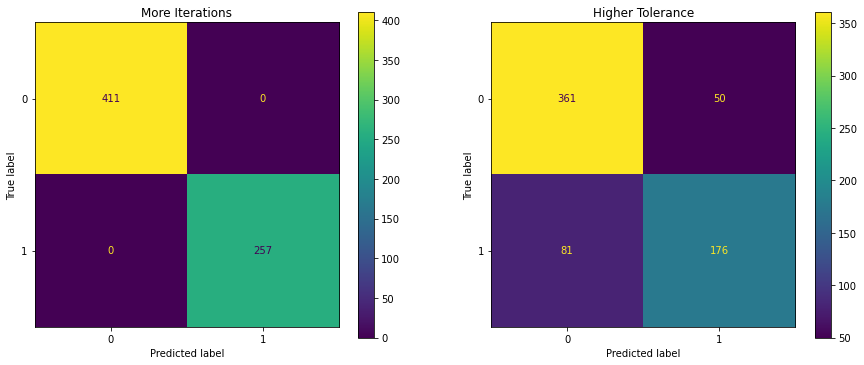

In [67]:
fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].set_title("More Iterations")
axes[1].set_title("Higher Tolerance")

ConfusionMatrixDisplay(confusion_matrix(y_train, log_pipe2.predict(X_train))).plot(ax=axes[0])
ConfusionMatrixDisplay(confusion_matrix(y_train, log_pipe3.predict(X_train))).plot(ax=axes[1]);

In [68]:
logreg_model_more_iterations_results = ModelWithCV(
                                        log_pipe2,
                                        'more_iterations',
                                        X_train,
                                        y_train
)
    
logreg_model_higher_tolerance_results = ModelWithCV(
                                        log_pipe3,
                                        'higher_tolerance',
                                        X_train,
                                        y_train
)

models = [
    logreg_model_more_iterations_results,
    logreg_model_higher_tolerance_results
]

In [69]:
log_pipe2.score(X_train, y_train)

1.0

In [70]:
log_pipe3.score(X_train, y_train)

0.8038922155688623

CV Results for `more_iterations` model:
            0.80384 ± 0.05298 accuracy
        
CV Results for `higher_tolerance` model:
            0.80540 ± 0.04055 accuracy
        


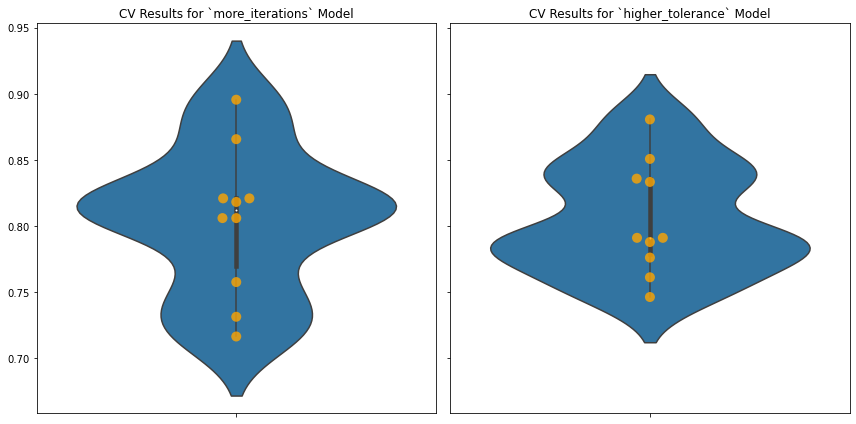

In [71]:
f,axes = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

for ax, result in zip(axes, models):
    ax = result.plot_cv(ax)
    result.print_cv_summary()
plt.tight_layout();

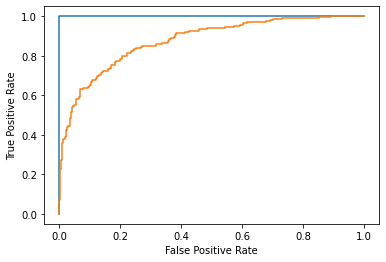

In [72]:
fig, ax = plt.subplots()

fpr2, tpr2, thresh2 = roc_curve(y_train, log_pipe2.predict_proba(X_train)[:,1]) 
fpr3, tpr3, thresh3 = roc_curve(y_train, log_pipe3.predict_proba(X_train)[:,1])

RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot(ax=ax)
RocCurveDisplay(fpr=fpr3, tpr=tpr3).plot(ax=ax);

> What can we observe from these two adjustments to our model with more features?

# Even More Data Preparation - Scaling

We saw that our last model is overfitting on so many features. A good strategy is to do regularization.

However, recall we should scale all of the features, so the model isn't overly penalizing age and fare.

In [75]:
num_pipeline2 = Pipeline(steps=[('im_num', num_imput), 
                               ('ss', StandardScaler())])

In [76]:
col_tr2 = ColumnTransformer(transformers=[('num', num_pipeline2, num_feats),
                                        ('cat', cat_pipeline, cat_feats)],
                          remainder='passthrough', sparse_threshold=0)

In [77]:
log_pipe4 = Pipeline([('ct', col_tr2), ('logreg', LogisticRegression(random_state=42))])

# 4th Model - After Scaling

Now that the data is scaled, let's see if we can fit the model without tweaking any hyperparameters.

In [78]:
log_pipe4.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('im_num',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Unknown',
                    

## Model Evaluation, Part 4

Now that we are able to run a logistic regression with default hyperparameters, let's see how that performs.

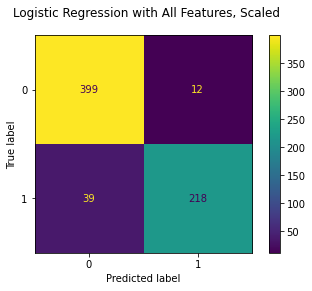

In [79]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with All Features, Scaled")

ConfusionMatrixDisplay(confusion_matrix(y_train, log_pipe4.predict(X_train))).plot(ax=ax)

In [80]:
log_pipe4.score(X_train, y_train)

0.9236526946107785

In [81]:
model_results = ModelWithCV(
                            log_pipe4,
                            'all_features',
                            X_train,
                            y_train
)

CV Results for `all_features` model:
            0.80995 ± 0.04250 accuracy
        


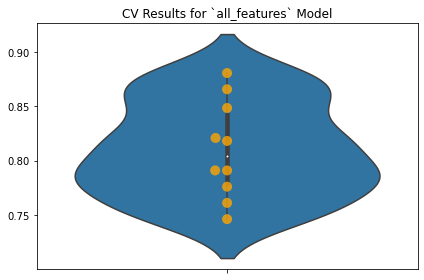

In [82]:
# Plot CV results
fig, ax = plt.subplots()
ax = model_results.plot_cv(ax)
plt.tight_layout();
# Print CV results
model_results.print_cv_summary()

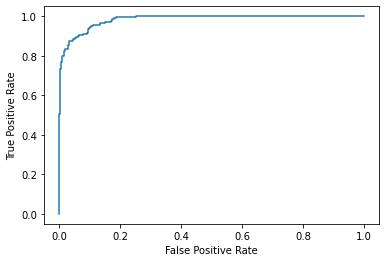

In [84]:
fpr4, tpr4, thresh4 = roc_curve(y_train, log_pipe4.predict_proba(X_train)[:,1])

RocCurveDisplay(fpr=fpr4, tpr=tpr4).plot();

Doing good on the training data, ~81% range on the test data ... this model is still overfitting.

# We should try hard feature elimination 

Recall what was happening with our name and ticket columns (OHE creating too many columns)

In [85]:
cat_feats

['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [86]:
num_feats = ['Age', 'SibSp', 'Parch', 'Fare']
cat_feats = ['Pclass', 'Sex', 'Cabin', 'Embarked']

In [88]:
col_tr3 = ColumnTransformer(transformers=[('num', num_pipeline2, num_feats),
                                        ('cat', cat_pipeline, cat_feats)],
                          remainder='drop', sparse_threshold=0)

log_pipe5 = Pipeline([('ct', col_tr3), ('logreg', LogisticRegression(random_state=42))])
log_pipe5.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('im_num',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Unknown',
                                             

In [89]:
col_tr3.fit_transform(X_train).shape

(668, 144)

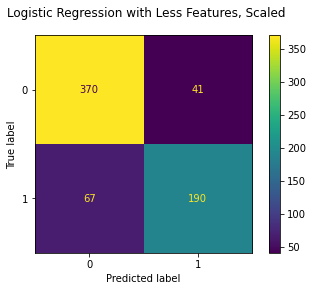

In [90]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with Less Features, Scaled")

ConfusionMatrixDisplay(confusion_matrix(y_train, log_pipe5.predict(X_train))).plot(ax=ax)

In [91]:
log_pipe5.score(X_train, y_train)

0.8383233532934131

In [92]:
model_results = ModelWithCV(
                            log_pipe5,
                            'less_features',
                            X_train,
                            y_train
)

CV Results for `less_features` model:
            0.80396 ± 0.04373 accuracy
        


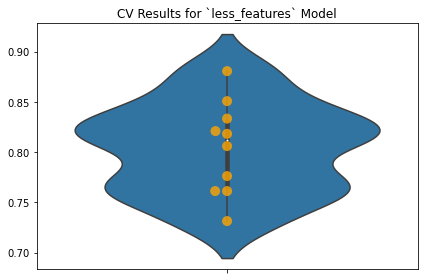

In [93]:
# Plot CV results
fig, ax = plt.subplots()
ax = model_results.plot_cv(ax)
plt.tight_layout();
# Print CV results
model_results.print_cv_summary()

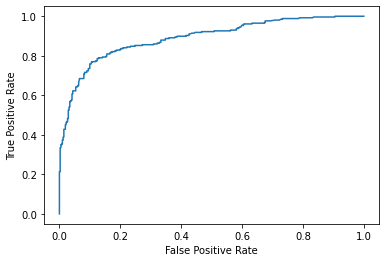

In [95]:
fpr4, tpr4, thresh4 = roc_curve(y_train, log_pipe5.predict_proba(X_train)[:,1])

RocCurveDisplay(fpr=fpr4, tpr=tpr4).plot();

## `SelectFromModel`

The all features model was probably overfitting. We might try thinning out the number of features by eliminating the ones with small modeling coefficients using [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)

In [96]:
selector = SelectFromModel(log_pipe4)

selector.fit(X_train, y_train)

SelectFromModel(estimator=Pipeline(steps=[('ct',
                                           ColumnTransformer(remainder='passthrough',
                                                             sparse_threshold=0,
                                                             transformers=[('num',
                                                                            Pipeline(steps=[('im_num',
                                                                                             SimpleImputer(add_indicator=True)),
                                                                                            ('ss',
                                                                                             StandardScaler())]),
                                                                            ['Age',
                                                                             'SibSp',
                                                                             'Parch',


We're using the default threshold here:

In [97]:
thresh = selector.threshold_

ValueError: The underlying estimator Pipeline has no `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to SelectFromModel or call fit before calling transform.

In [98]:
log_pipe4.coef_

AttributeError: 'Pipeline' object has no attribute 'coef_'

In [100]:
log_pipe4.named_steps

{'ct': ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                   transformers=[('num',
                                  Pipeline(steps=[('im_num',
                                                   SimpleImputer(add_indicator=True)),
                                                  ('ss', StandardScaler())]),
                                  ['Age', 'SibSp', 'Parch', 'Fare']),
                                 ('cat',
                                  Pipeline(steps=[('impute_cat',
                                                   SimpleImputer(add_indicator=True,
                                                                 fill_value='Unknown',
                                                                 strategy='constant')),
                                                  ('ohe',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabi

In [105]:
log_pipe4.named_steps['ct'].named_transformers_['num']

Pipeline(steps=[('im_num', SimpleImputer(add_indicator=True)),
                ('ss', StandardScaler())])

In [99]:
log_pipe4.named_steps['logreg'].coef_

array([[-0.58476279, -0.50692164, -0.06335946, ..., -0.29485196,
        -0.07606817,  0.07598832]])

In [106]:
X_train_tr = col_tr2.fit_transform(X_train)

In [107]:
selector = SelectFromModel(LogisticRegression(random_state=42))
selector.fit(X_train_tr, y_train)

SelectFromModel(estimator=LogisticRegression(random_state=42))

In [108]:
thresh = selector.threshold_
thresh

0.20195990842614955

Let's get a sense of which features will be eliminated:

In [109]:
coefs = selector.estimator_.coef_
coefs

array([[-0.58476279, -0.50692164, -0.06335946, ..., -0.29485196,
        -0.07606817,  0.07598832]])

In [110]:
coefs.shape

(1, 1349)

In [111]:
coefs[abs(coefs) > thresh].shape

(486,)

In [112]:
selector.get_support()

array([ True,  True, False, ...,  True, False, False])

In [113]:
X_train_sel = selector.transform(X_train_tr)

In [114]:
X_train_tr.shape

(668, 1349)

In [115]:
X_train_sel.shape

(668, 486)

In [116]:
log_reg_6 = LogisticRegression(random_state=42)

In [117]:
log_reg_6.fit(X_train_sel, y_train)

LogisticRegression(random_state=42)

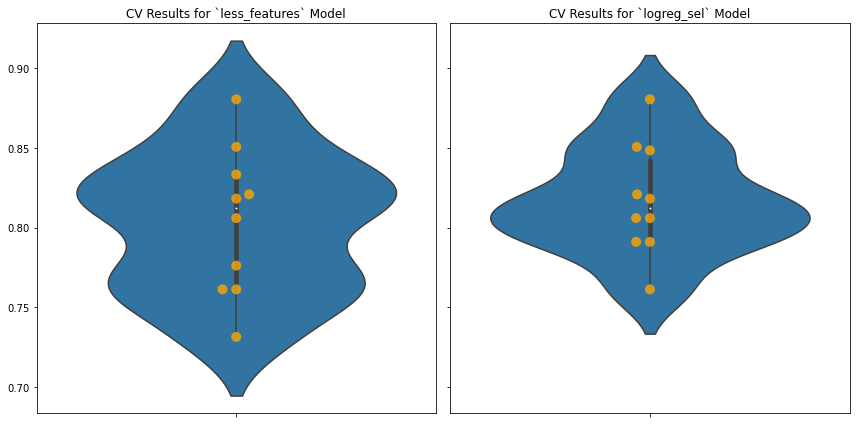

In [118]:
# Save for later comparison
select_results = ModelWithCV(
                    log_reg_6, 
                    'logreg_sel',
                    X_train_sel,
                    y_train
)

# Plot both all_features vs new model
f,axes = plt.subplots(ncols=2, sharey='all', figsize=(12, 6))

model_results.plot_cv(ax=axes[0])
select_results.plot_cv(ax=axes[1])

plt.tight_layout();

In [119]:
print("Old:", model_results.cv_results.mean())
print("New:", select_results.cv_results.mean())

Old: 0.8039574853007687
New: 0.817412935323383


Probably still overfitting, but let's call this our final model!

# Final Model Evaluation

Now that we have a final model, we would transform our X_test in accordance to what we did to X_train: Missing Indicators, Imputations, One Hot Encoding, Scaling, etc....

In [120]:
X_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
840,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S
554,3,"Ohman, Miss. Velin",female,22.0,0,0,347085,7.7750,NaN,S
214,3,"Kiernan, Mr. Philip",male,NaN,1,0,367229,7.7500,NaN,Q
439,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
366,1,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",female,60.0,1,0,110813,75.2500,D37,C
...,...,...,...,...,...,...,...,...,...,...
766,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C
136,1,"Newsom, Miss. Helen Monypeny",female,19.0,0,2,11752,26.2833,D47,S
148,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.5,0,2,230080,26.0000,F2,S
297,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,C22 C26,S


Create a model with the relevant hyperparameters, fit, and score

In [121]:
X_test_tr = col_tr2.transform(X_test)
X_test_tr.shape

(223, 1349)

In [122]:
X_test_sel = selector.transform(X_test_tr)
X_test_sel.shape

(223, 486)

In [123]:
final_model = LogisticRegression(random_state=42)

final_model.fit(X_train_sel, y_train)

final_model.score(X_test_sel, y_test)

0.8026905829596412

In [124]:
final_model2 = Pipeline(steps=[('ct', col_tr2),
                               ('selector', SelectFromModel(LogisticRegression(random_state=42))),
                               ('logreg', LogisticRegression(random_state=42))])

In [125]:
final_model2.fit(X_train, y_train)
final_model2.score(X_test, y_test)

0.8026905829596412

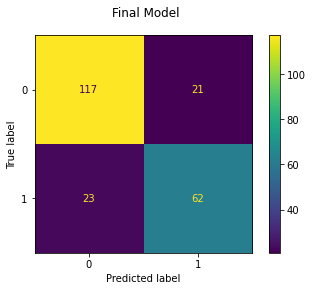

In [126]:
fig, ax = plt.subplots()

fig.suptitle("Final Model")

ConfusionMatrixDisplay(confusion_matrix(y_test, final_model2.predict(X_test))).plot(ax=ax)

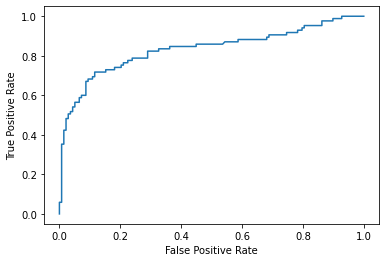

In [129]:
fpr, tpr, thresh = roc_curve(y_test, final_model2.predict_proba(X_test)[:,1])

RocCurveDisplay(fpr=fpr, tpr=tpr).plot();

In [135]:
print(classification_report(y_test, final_model2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       138
           1       0.75      0.73      0.74        85

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



In [130]:
final_model3 = Pipeline(steps=[('ct', col_tr3),
                               ('selector', SelectFromModel(LogisticRegression(random_state=42))),
                               ('logreg', LogisticRegression(random_state=42))])

In [131]:
final_model3.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('im_num',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Unknown',
                                             

In [133]:
#final_model3.fit(X_train, y_train)
final_model3.score(X_test, y_test)

0.7713004484304933

In [134]:
final_model3.score(X_train, y_train)

0.8323353293413174

# Exercise

Build and iterate on a logistic regression model of **color** for the diamonds dataset! Maximize accuracy.

In [136]:
diamonds = sns.load_dataset('diamonds')

In [137]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
